**Imports**

In [3]:
!pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.1 MB/s eta 0:00:00


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
from imblearn.over_sampling import SMOTE
from scipy.stats import randint


**Load & Preprocess Data**

In [5]:

df = pd.read_csv('exoplanets.csv')

# Drop irrelevant columns
columns_to_drop = [
    'kepid', 'kepoi_name', 'kepler_name',
    'koi_tce_delivname', 'koi_pdisposition',
    'koi_teq_err1', 'koi_teq_err2'
]
df = df.drop(columns=columns_to_drop)

# Features / Target
X = df.drop('koi_disposition', axis=1)
y = df['koi_disposition']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


**Handle Imbalance with SMOTE**

In [6]:
# =========================
# Part 3: Balance Dataset with SMOTE
# =========================
print("Class distribution before SMOTE:", np.bincount(y_train))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:", np.bincount(y_train_res))


Class distribution before SMOTE: [1893 1886 3872]
Class distribution after SMOTE: [3872 3872 3872]


**Hyperparameter Tuning**

In [11]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}


rand_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)


rand_search.fit(X_train_res, y_train_res)
best_model = rand_search.best_estimator_


print("Best Parameters:", rand_search.best_params_)

Best Parameters: {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 413}


**Threshold Optimization**

In [12]:

y_probs = best_model.predict_proba(X_test)
n_classes = y_probs.shape[1]
best_thresholds = []

for i in range(n_classes):
    thresholds = np.linspace(0.1, 0.9, 50)
    best_acc, best_t = 0, 0.5
    for t in thresholds:
        y_pred_temp = []
        for probs in y_probs:
            if probs[i] >= t:
                y_pred_temp.append(i)
            else:
                y_pred_temp.append(np.argmax(probs))
        acc = accuracy_score(y_test, y_pred_temp)
        if acc > best_acc:
            best_acc, best_t = acc, t
    best_thresholds.append(best_t)

print("Best Thresholds per class:", best_thresholds)

# Apply thresholds
y_pred_final = []
for probs in y_probs:
    adjusted = [1 if probs[i] >= best_thresholds[i] else 0 for i in range(n_classes)]
    if sum(adjusted) == 0:  # fallback: choose max prob
        y_pred_final.append(np.argmax(probs))
    else:
        y_pred_final.append(np.argmax(adjusted))
y_pred_final = np.array(y_pred_final)


Best Thresholds per class: [np.float64(0.49183673469387756), np.float64(0.4102040816326531), np.float64(0.44285714285714284)]


**Evaluation**

In [13]:
# =========================
# Part 6: Final Evaluation
# =========================
print("\nClassification Report (Optimized Thresholds):")
print(classification_report(y_test, y_pred_final, target_names=le.classes_))

accuracy = accuracy_score(y_test, y_pred_final)
precision_macro = precision_score(y_test, y_pred_final, average='macro')
recall_macro = recall_score(y_test, y_pred_final, average='macro')
f1_macro = f1_score(y_test, y_pred_final, average='macro')
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"ROC AUC (Macro): {roc_auc:.4f}")

# Cross-validation score
cv_scores = cross_val_score(best_model, X_train_res, y_train_res, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))



Classification Report (Optimized Thresholds):
                precision    recall  f1-score   support

     CANDIDATE       0.80      0.83      0.82       474
     CONFIRMED       0.84      0.84      0.84       471
FALSE POSITIVE       0.99      0.98      0.98       968

      accuracy                           0.91      1913
     macro avg       0.88      0.88      0.88      1913
  weighted avg       0.91      0.91      0.91      1913

Accuracy: 0.9059
Precision (Macro): 0.8784
Recall (Macro): 0.8806
F1 Score (Macro): 0.8795
ROC AUC (Macro): 0.9753
Cross-Validation Accuracy Scores: [0.90662651 0.90615583 0.91304348 0.94231597 0.93499785]
Mean CV Accuracy: 0.9206279271195846


**Visualization**

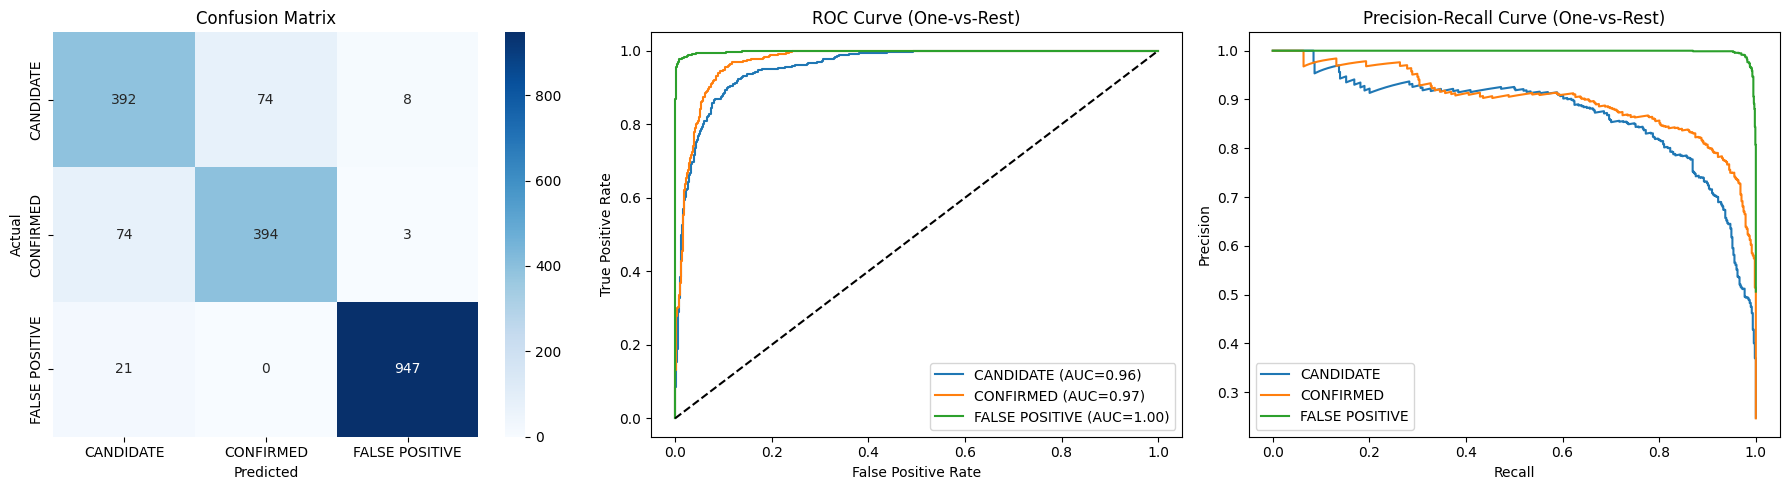

In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize labels (One-vs-Rest)
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Ensure y_probs has shape [n_samples, n_classes]
# y_probs = model.predict_proba(X_test)  # should be probabilities

# ========== Plot ========== #
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve (One-vs-Rest, macro)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={roc_auc:.2f})")

axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("ROC Curve (One-vs-Rest)")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

# Precision-Recall Curve (One-vs-Rest)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_probs[:, i])
    axes[2].plot(recall, precision, label=f"{le.classes_[i]}")

axes[2].set_title("Precision-Recall Curve (One-vs-Rest)")
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].legend()

plt.tight_layout()
plt.show()

